# Homework 5 - Visit the Wikipedia hyperlinks graph!

*Group 34: Eleonora Barocco, Mahtab Fotovat, Fabio Montello, Farid Rasulov,*

In this assignment we want to perform some analysis of the Wikipedia Hyperlink graph. In particular, given extra information about the categories to which an article belongs to, we are curious to rank the articles according to some criteria.

<img src="https://raw.githubusercontent.com/fabiomontello/Homework5_Group-34/master/data/complex-graph.png" width="600">

## Retrieve the data

In the first place we want to retrieve all the data needed. We start from the list of categories and the names of the pages that for the Wikipedia graph, that will be downloaded from [SNAP group's webpage](https://snap.stanford.edu/data/wiki-topcats.html). Then we proceed by downloading a [reduced version](https://drive.google.com/file/d/1ghPJ4g6XMCUDFQ2JPqAVveLyytG8gBfL/view) of the links in between nodes, provided along with the homework instructions.

Before starting exploring the research questions provided, we also want to import all the libraries we will need later on. In this way we will keep the code tidy and clear, hoping it will be also less confusing for the readers.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections 
from multiprocessing import Pool

## [RQ1] Datamining to build the graph

In this first part we want to build the graph $G=(V, E)$, where $V$ is the set of articles and $E$ the hyperlinks among them, and provide its basic information:

- If it is direct or not
- The number of nodes
- The number of edges
- The average node degree. Is the graph dense?

We start by getting the nodes we want to build our graph from. Since we are interested only in the nodes that are connected in some way to each other, we will considere just the nodes that appear in `wiki-topcats-reduced.txt`, which is the reduce file containing all the links between nodes we will need to build our rank later on.

In [2]:
data = pd.read_csv('data/wiki-topcats-reduced.txt', sep="	", header=None) #Read values with pandas
data.columns = ["from", "to"]

Our intial data are rappresented in a series of edges between nodes.

In [3]:
data.head()

,from,to
0,52,401135
1,52,1069112
2,52,1163551
3,62,12162
4,62,167659


The first thing we want is to obtain a list of nodes: we created two sets (which don't contain duplicates) with the nodes included in the two columns and then the union of the two set in a single final set. The lenght of this set is equal to the number of nodes.

In [4]:
list1 = data["from"].values #Starting points of the links
list2 = data["to"].values #Ending points of the links
set1=set(list1)
set2=set(list2)
fin_set = set1.union(set2)
print('Number of nodes: ',len(fin_set))
print('Number of edges: ',len(data.index))

Number of nodes:  461193
Number of edges:  2645247


A simple check to know wheter the graph is directed or not is to calculate the lenght of both sets: if they are different we can say that it is actually directed.

In [5]:
print(len(set1))
print(len(set2))

428957
352518


Since the lenghts are different we can say the graph is **directed**.   

We choose to use Networkx library as base to build our graph, since it's already optimized and has all the tools necessary later on to store the data we need. We read the previous set to insert nodes and the pandas table to add the edges:

In [12]:
G = nx.DiGraph() #Create a directed graph
G.add_nodes_from(fin_set, categories = [])
for i in range(len(data)):
    G.add_edge(data.iloc[i]['from'], data.iloc[i]['to'])

And we want to double check that the number of nodes we computed before is equal to the the one the library returns us:

In [14]:
a= sorted(list(G.nodes()))
len(a)

461193

Now we want to review all the informations we wanted to retrieve in RQ1 in one place, so to have all the basic informations together. These are number of nodes, number of edges, type of graph and density of the graph which is calculate as: <br>
<h1><center>$ D = \frac{\lvert E \rvert} {\lvert V \rvert (\lvert V \rvert - 1)}  \simeq \frac{\lvert E \rvert} {V^2}$</center></h1>

In [15]:
nodes = G.number_of_nodes()
edges = G.number_of_edges()
print('The graph is ', "undirected" if(set1 == set2) else "directed")
print('Number of nodes: ' + str(nodes))
print('Number of edges: ' + str(edges))
print('Density: ' + str(edges/(nodes**2)))

The graph is  directed
Number of nodes: 461193
Number of edges: 2645247
Density: 1.243657566949106e-05


Since the value of density is really close to zero, we can say that it's **sparse graph**.

## [RQ2]  Datamining to find categories

Given a category $C_0 = \{article_1, article_2, \dots \}$ as input we want to rank all of the nodes in $V$ according to a block-ranking, where the blocks are represented by the categories.

First of all, we want to read all the categories from the file containing them. 

In [16]:
# creating a dictionary of tuples in which the first element is the name of that category
#and the second element is the list of articles in that category 
categoriesdata = {}
with open('wiki-topcats-categories.txt') as f:
    for i, line in enumerate(f):
        tmp = line.split(';')
        categoriesdata[i] = (tmp[0].replace('Category:', ''), [int(i) for i in tmp[1].split()])
f.close()

In [17]:
len(categoriesdata)

17364

We obtained in total 17364 categories raw categories. Since we are using a reduced number of nodes, we proceed filtering just the nodes we actually have in our graph (so the ones that are linked each other) and also we want to filter all the categories that do not have at least 3500 elements.
In each node we will also add the list of categories it belongs to. This will help us later.

In [18]:
#we fill the list of categories for every node in the graph
#updating the category feature for every node in graph 

for elem in categoriesdata: #for every key( category) in the categories dictionary
    for node in categoriesdata[elem][1]: # for every node in the list
        if(node in fin_set): # if node is connected
            if len(categoriesdata[elem][1]) > 3500: #if the length of list is more than 3500
                ncat = G.node[node]['categories'] + [categoriesdata[elem][0]] #get the list of categories and add the new category
                G.node[node].update(categories = ncat) # update the category feature in the graph

In [19]:
# create a dictionary of all the categories if their number of articles are more than 3500
# the key of the dictionary is the name of the category and the value is all the nodes in the category
# which are connected

categories = dict()
for tpl in categoriesdata:
    if len(categoriesdata[tpl][1]) > 3500:
        categories[categoriesdata[tpl][0]] = [node for node in categoriesdata[tpl][1] if node in fin_set]

In [20]:
print('Number of categories:', len(categories))

Number of categories: 35


Let's print all the categories we will take in to a account with their relative length:

In [21]:
for i in categories:
    print(i.rjust(70),' ', len(categories[i]))

                                                   English_footballers   7538
                                           The_Football_League_players   7814
                                         Association_football_forwards   5097
                                      Association_football_goalkeepers   3737
                                      Association_football_midfielders   5827
                                        Association_football_defenders   4588
                                                         Living_people   348300
                                                 Year_of_birth_unknown   2536
                                             Harvard_University_alumni   5549
                                        Major_League_Baseball_pitchers   5192
   Members_of_the_United_Kingdom_Parliament_for_English_constituencies   6491
                                                          Indian_films   5568
                                                 Year_of_death

## Block-ranking

In the process of building our block ranking, we need to take into account:

$$distance(C_0, C_i) = median(ShortestPath(C_0, C_i))$$

Were $C_0$ is an arbitrary category set as an input(in this case, chosen by us) and $C_i$ all the other categories, one by one. The lower is the distance from $C_0$, the higher is the $C_i$ position in the rank. We want to consider $ShortestPath(C_0, C_i)$ is the set of all the possible shortest paths between the nodes of $C_0$ and $C_i$. Moreover, the length of a path is given by the sum of the weights of the edges it is composed by, which, since the graph is unweighted, it's equal to 1.

Basically we want to compute all the shortest distances between points from the category we choose to any other category, and than just keep the median (central value) of all the values we obtained for each category

The first thing we want to do is to choose a category as input that will let us reduce the number of computations we have to perform, since the graph has a huge number of nodes and edges. So the logical way to go is to pick the category with the least number of elements as $C_0$.

In [22]:
minimum = 10000000
input_category = ''
for i in categories:
    if(int(len(categories[i])) < minimum):
        minimum = len(categories[i])
        input_category = i
        
print(input_category, minimum )

Year_of_birth_unknown 2536


As we can see the category `Year_of_birth_unknown` is the smallest one, containing only 2536 elements. So this will become our $C_0$.

Next step is to compute every single distance in between the nodes from $C_0$ and every other category in our graph. Since it will take some time to execute, we suggest to avoid executing the algorithm if not necessary. In fact, once it has been executed, it will store all the value retrieved, so that further blocks of codes can be executed inependently, as long as the files precomputed are saved in the subdirectory `data`.
Since the code require some time to be executed, we decided also to parallelize the computation of the distances between nodes, so to use all the CPU power that is available on the compiling machine and reduce massively the execution time.

We know from the beginning that all the nodes we have in the graph will be part of a category, so we easly want to go from a single point thorugh all the graph, and for each node we encounter, we'll add the distance from $C_0$, this for the whole graph. We will have to repeat this just for all the nodes in $C_0$.

In [23]:
inf=float("inf")
#writing empty files for each category that has more than 3500 articles and connected nodes
for category in categories:
    file=open("data/" + category, "w")
    file.close()

print("Sources:/n")
#BFS algo
def compute(source):

    print(source)
    
    level=0 #initializing the level zero as the starting level
    current_level=set() #initializing current level as an empty set
    next_level=set() #initializing next level as an empty set
    current_level.add(source) # in the first step current level is equal to the source
    visited=set() #initializing visited nodes as an empty set
    
    for link in list(G.neighbors(source)): #for iterating over the source's neighbors
        next_level.add(link) #add source's neighbors to the next level
    
    while next_level!=set(): #while next level is not empty
    
        next_level=set() # we re-initialize the next level
    
        for node in current_level: # assign the current level nodes to the visited set
            visited.add(node)

            if node == source: # if the node is source
                for category in G.node[node]['categories']: #for category in node's list of categories
                    file=open("data/" + category, "a") # opening the file with corresponding category
                    file.write("0")
                    file.write("/n")
                    file.close()
                    
            elif node!=source: #if the node is not the source
                for category in G.node[node]['categories']: #for category in node's list of categories
                    file=open("data/" + category, "a") # opening the file with corresponding category
                    file.write(str(level))
                    file.write("/n")
                    file.close()
       
            #filling the next level
            for link in list(G.neighbors(node)): 
                if link not in visited:
                    next_level.add(link)
                    
        level+=1
        current_level=next_level

pool = Pool() #initializing the multi core processing
pool.map(compute, categories[input_category]) # mapping the compute function to all the nodes in the input category
pool.close() # close the multi core processing object 
pool.join()# provides synchronization for possible debugging outputs

What we have stored now are 35 files named with the names of the categories, where in every file we have the distances between every node in $C_0$ and every other node in the graph. In this way we will be able to reopen the files again later on, and compute the distances we need with the points in order to get the median value for every category. 

In [24]:
#calculating median of distances for each category from input category

category_dict=dict() #dictionary of distances between input category and every other category

for category in categories: # for each category
    
    if category == input_category: # if the category is the input category
        
        print(category)
        print(0.0)
        category_dict[category]=0. # set the distance to 0.0 by default
        
        
    else: # if the category is not the input category
        
        print(category)

        file=open("C:/Users/user-01/Desktop/ADM HW5/files/" + category, "r") # open the file of the category
        content=file.read().splitlines() #create a list of each line(distances)
        file.close()

        content=list(map(float, content)) #change type of the content to float

        content.sort() #sort the content(distances)

        missing_infinities=len(categories[input_category])*len(categories[category])-len(content) #computing the number of missing inf distances in the category file

        if (len(content) + missing_infinities)%2 != 0: #if the total number of distances is odd
            median_index = int(((len(content) + missing_infinities)-1)/2 + 1) # calculating the median index
            if median_index < len(content): # check if the median index falls inside the finite distances
                median = content[median_index] # get the corresponding value of this index
            else: #if the median falls in the infinite distances
                median = inf # corresponding value will be infinity

        if (len(content) + missing_infinities)%2 == 0: #if the total number of distances is even
            median_index1 = int(((len(content) + missing_infinities)-1)/2) # calculating the median index1
            median_index2 = int(((len(content) + missing_infinities)-1)/2 + 1) # calculating the median index2
            if (median_index1 < len(content)) and (median_index2 < len(content)): #check if the median index1 and median index2 falls inside the finite distances
                median = (content[median_index1] + content[median_index2])/2 # take the mean of the values for median index1 and median index2
            else: #if the median index1 and /or median index2 falls inside the infinite distances
                median = inf  # corresponding value will be infinity

        print(median)
        category_dict[category]=median #providing median of category_dict for each category

We want to sort the data obtained increasing by the score we computed previously.

In [25]:
sorted_category = sorted(category_dict.items(), key=lambda kv: kv[1])
sorted_category

[('Year_of_birth_unknown', 0.0),
 ('English_television_actors', 6.0),
 ('British_films', 6.0),
 ('English-language_films', 6.0),
 ('American_films', 6.0),
 ('American_Jews', 6.0),
 ('American_television_actors', 6.0),
 ('American_film_actors', 6.0),
 ('Article_Feedback_Pilot', 6.0),
 ('Harvard_University_alumni', 7.0),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 7.0),
 ('Indian_films', 7.0),
 ('English-language_albums', 7.0),
 ('Fellows_of_the_Royal_Society', 7.0),
 ('People_from_New_York_City', 7.0),
 ('Debut_albums', 7.0),
 ('Black-and-white_films', 7.0),
 ('American_military_personnel_of_World_War_II', 7.0),
 ('The_Football_League_players', 8.0),
 ('Living_people', 8.0),
 ('Major_League_Baseball_pitchers', 8.0),
 ('Year_of_birth_missing_(living_people)', 8.0),
 ('Rivers_of_Romania', 8.0),
 ('Place_of_birth_missing_(living_people)', 8.0),
 ('Windows_games', 8.0),
 ('English_footballers', 9.0),
 ('Association_football_forwards', 9.0),
 ('English_cricketers

## Weight nodes and creating the subgraph

Now, based on the rank we retrieved previously, we want to give a rank to the single nodes.

In [27]:
rank = [elem[0] for elem in sorted_category]
rank

['Year_of_birth_unknown',
 'English_television_actors',
 'British_films',
 'English-language_films',
 'American_films',
 'American_Jews',
 'American_television_actors',
 'American_film_actors',
 'Article_Feedback_Pilot',
 'Harvard_University_alumni',
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
 'Indian_films',
 'English-language_albums',
 'Fellows_of_the_Royal_Society',
 'People_from_New_York_City',
 'Debut_albums',
 'Black-and-white_films',
 'American_military_personnel_of_World_War_II',
 'The_Football_League_players',
 'Living_people',
 'Major_League_Baseball_pitchers',
 'Year_of_birth_missing_(living_people)',
 'Rivers_of_Romania',
 'Place_of_birth_missing_(living_people)',
 'Windows_games',
 'English_footballers',
 'Association_football_forwards',
 'English_cricketers',
 'Association_football_goalkeepers',
 'Association_football_midfielders',
 'Association_football_defenders',
 'Year_of_death_missing',
 'Main_Belt_asteroids',
 'Asteroids_named_for_people

### Cleaning the categories

Once we obtained the rank we want to clean the categories: all the elements in the input category belong to that one, but from the second category we want to remove the elements that already are in the previous ones.
<br>
We stored the initial lenght of the categories in a list 'len_'

In [28]:
len_=[]
for i in range(len(categories)):
    len_.append(len(categories[rank[i]]))

In [29]:
# clean ranked categories
for i in range(len(rank)):
    if i == 0:
        used_nodes = set(categories[rank[i]])
        categories[rank[i]] = set(categories[rank[i]])
    else:
        categories[rank[i]] = set(categories[rank[i]]).difference(used_nodes)
        used_nodes = used_nodes.union(categories[rank[i]])

In [30]:
for i in range(len(categories)):
    len_[i] = (len_[i],len(categories[rank[i]]))

Now the list 'len_' contains tuples with the old and the new lenght of the cagories.
<br>
We can see how the number of nodes in the following categories decrese.

In [31]:
len_

[(2536, 2536),
 (3362, 3361),
 (4422, 4422),
 (22463, 18909),
 (15159, 4598),
 (3411, 3400),
 (11531, 11065),
 (13865, 4766),
 (3485, 3418),
 (5549, 5296),
 (6491, 6473),
 (5568, 5533),
 (4760, 4747),
 (3446, 3169),
 (4614, 3429),
 (7561, 6648),
 (10759, 3489),
 (3720, 3183),
 (7814, 7793),
 (348300, 319681),
 (5192, 1931),
 (28498, 74),
 (7729, 7729),
 (5532, 43),
 (4025, 4013),
 (7538, 1012),
 (5097, 254),
 (3275, 1839),
 (3737, 161),
 (5827, 122),
 (4588, 117),
 (4122, 3527),
 (11660, 11659),
 (4895, 358),
 (4346, 2438)]

Now we can start creating a subgraph induced by $C_0$:

- For each node in $C_0$ we computed the sum of the weights of the in-edges, giving a weight to them
- Then we want to extend the graph to the nodes of the next category in the rank: immagine $C_1$ is our second category, we first calculate the score as before, then we calculate the in-edges coming from the previous category, that will give as weight as the score of the nodes that sends to the edge.
- We repeat the same for all the categories.

In [32]:
used_nodes = []

For our purpose we defined two functions: one to calculate the weight of nodes given by the internal edges in the category

In [33]:
def weight_nodes (category):
    '''Takes in input a category as a set, returns a list with every node and its weight, 
    sorted according to the highest weights of the nodes (articles)'''
    #creating a vector of tuples which will contain the weight of nodes
    W = []
    for i in category:
        pred = set(G.predecessors(i))
        
        V = [i, len(pred)]        
        W.append(V)
    
    W = sorted(W,key=lambda x: x[1], reverse = True)  
    return W     

The second one assigns to the nodes the weight given from the nodes in the same category and the ones in the previous category.

In [34]:
def weight_nodes2 (category, prev_wei):
    '''Takes in input a category as a set and the other as a list with the weights of internal nodes.
    Returns a list with the internal weight plus the external given from the previous category, 
    sorted according to the highest weights of the nodes (articles)'''
    
    W = weight_nodes(category)
    
    #add the weight given by the previous category
    for i in range(len(W)):
        a = list(G.predecessors(W[i][0]))
        
        #for each predecessor check if the node is in the previous category, 
            #if it is, add the weight of the predecessor to the successor, 
            
        for y in range(len(a)):
            for j in range(len(prev_wei)):
                if a[y] == prev_wei[j][0]:
                    
                    W[i][1] += prev_wei[j][1]
                    break
            
    #calculating the weight    
        
    W = sorted(W,key=lambda x: x[1], reverse = True)    
    return W 

It's time to start calculating the weight: the first category only consider the internal nodes.

In [61]:
#first category
weight = []

C = [categories[rank[0]]]

weight.append(weight_nodes(C[0]))

weight[0][:20]


[[958480, 40],
 [1656246, 33],
 [584219, 25],
 [1203095, 25],
 [62684, 23],
 [1379114, 22],
 [1045188, 22],
 [170163, 22],
 [1270167, 21],
 [1656780, 20],
 [173007, 18],
 [1268881, 18],
 [1656777, 17],
 [1656778, 17],
 [1045180, 17],
 [54923, 16],
 [169696, 16],
 [87370, 14],
 [1123122, 13],
 [1656276, 13]]

Then for all the other we can apply the second function that also consider the weight from the previous category.

In [ ]:
# weight of nodes of other categories
#while add the edges between each category and the previous (thanks to function weight_nodes2)
for i in range(len(rank)):
    
    if i == 0:
        continue
    else:
        
        C = categories[rank[i]]
 
        w = weight_nodes2(C, weight[i-1])
        
        weight.append(w)


In [60]:
weight[3][:20]

[[1061310, 7458],
 [1058611, 4763],
 [1044631, 4270],
 [479828, 4216],
 [1042784, 4038],
 [1062638, 3574],
 [1061160, 3561],
 [1061285, 3533],
 [1060315, 3467],
 [1063046, 3428],
 [1062453, 3367],
 [1044627, 3302],
 [1062344, 3224],
 [1061187, 3186],
 [1043120, 3112],
 [1061272, 3088],
 [749106, 2956],
 [1062870, 2851],
 [1226630, 2792],
 [1042737, 2771]]

We have the weight of all the nodes but we want to create a subgraph as said before.

### Subgraph

Once we computed in every node in the categories lower than $C_0$ the sum of the weigths, we want now to create a subgraph starting from our chosen category, and then extending it to the next category in the rank, until we reach the last one. So for each category we want to keep just the edges that:
- connects to each other inside the category
- connects the category to the next one in the rank

To do so, we need to start by creating a new graph, which will be our subgraph:

In [40]:
F = nx.DiGraph()

Then, for each category, we want to add the nodes with the computed weight, the correct edges inside the category and the edges between the current category and the next one in the rank. In the case we are dealing with the first category, we will just connect the edges between nodes.

In [59]:
c0 = [] #Previous category nodes
c1 = [] #Current category nodes
for i in range(len(weight) -1):
    if(i == 0):
        c1 = [elem[0] for elem in weight[i]] #Get out all the nodes in the current category
        
        for elem in weight[i]:  # Add all the nodes in the category with their score
            F.add_node(elem[0], weight=elem[1])
        
        # Add all the edges inside the category
        for idx, elem in data.loc[data['from'].isin(c1) & data['to'].isin(c1)].iterrows(): 
            F.add_edge(int(elem.values[0]), int(elem.values[1])) 
    else:
        c0 = c1 #keep a copy of the previuous category
        c1 = [elem[0] for elem in weight[i]] #Get out all the nodes in the current category
        
        for elem in weight[i]: # Add all the nodes in the category with their score
            F.add_node(elem[0], weight=elem[1])
        
        # Add all the edges inside the category
        for idx, elem in data.loc[data['from'].isin(c1) & data['to'].isin(c1)].iterrows():
            F.add_edge(int(elem.values[0]), int(elem.values[1])) 
        
        # Add all the edges in between the current and the previous category
        for idx, elem in data.loc[data['from'].isin(c0) & data['to'].isin(c1)].iterrows():
            F.add_edge(int(elem.values[0]), int(elem.values[1])) 

Let's compare the graph and the subgraph:

In [51]:
print(nx.info(F)) # subgraph

Name: 
Type: DiGraph
Number of nodes: 458755
Number of edges: 1210943
Average in degree:   2.6396
Average out degree:   2.6396


In [66]:
print(nx.info(G)) # initial graph

Name: 
Type: DiGraph
Number of nodes: 461193
Number of edges: 2645247
Average in degree:   5.7357
Average out degree:   5.7357


As we can see, the number of nodes is slightly different, because of the nodes we filtered previously. The number of edges instead is less than half and so the degree of nodes per node.

Let's try now to plot the subgraph, to see if it can make sense visualizing it.   
We start with only the first category:

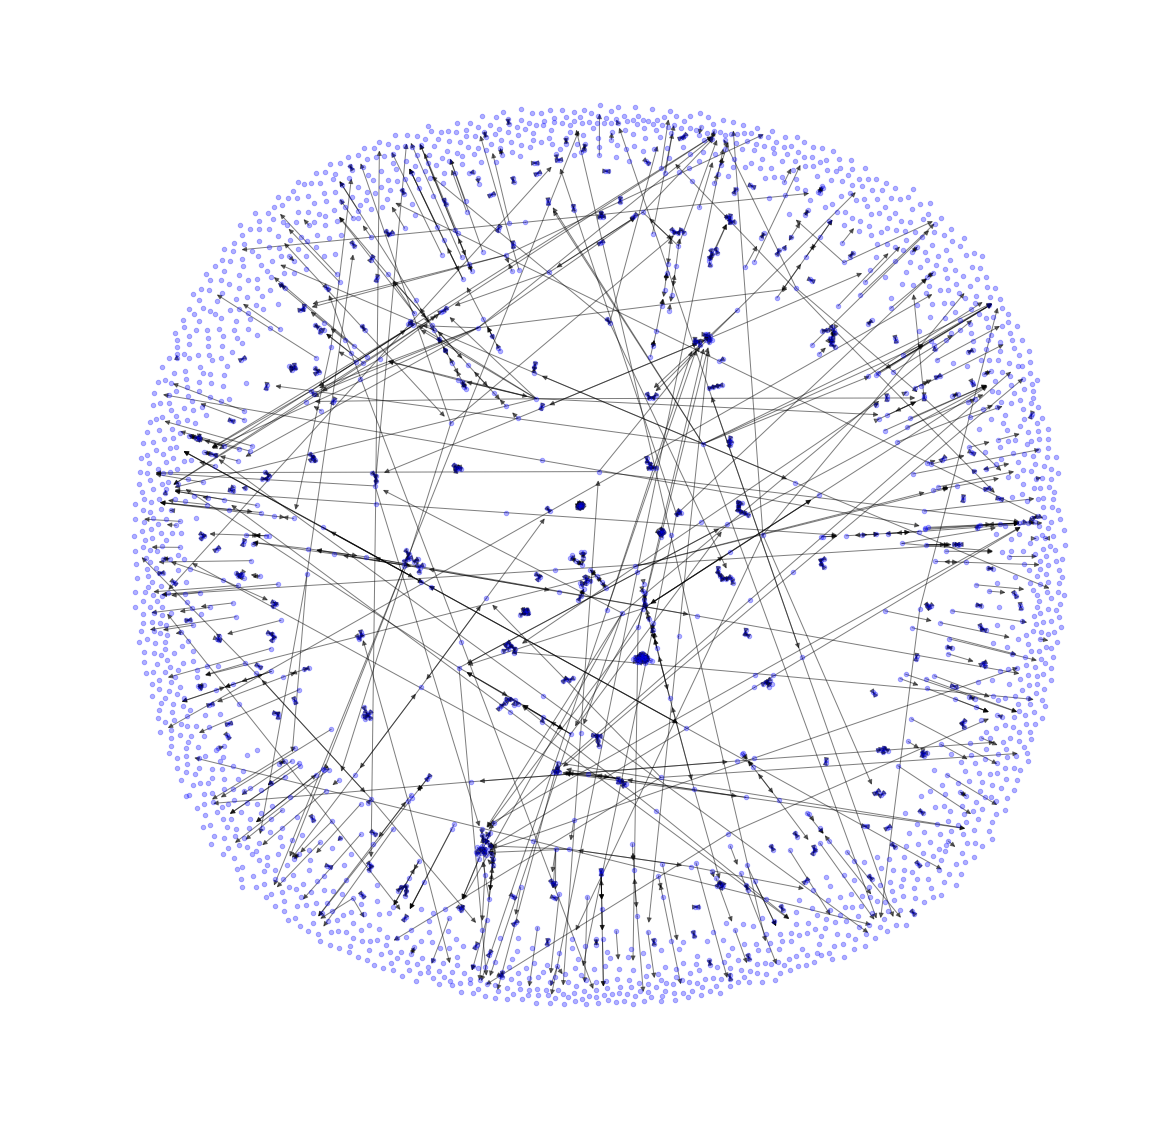

In [55]:
T = F.subgraph([elem[0] for elem in weight[0]])
pos = nx.spring_layout(T)  # compute graph layout
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(T, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color='blue', alpha=0.3)
nx.draw_networkx_edges(T, pos, alpha=0.5)
plt.show(T)

Let's include now also the second and third categories in the rank:

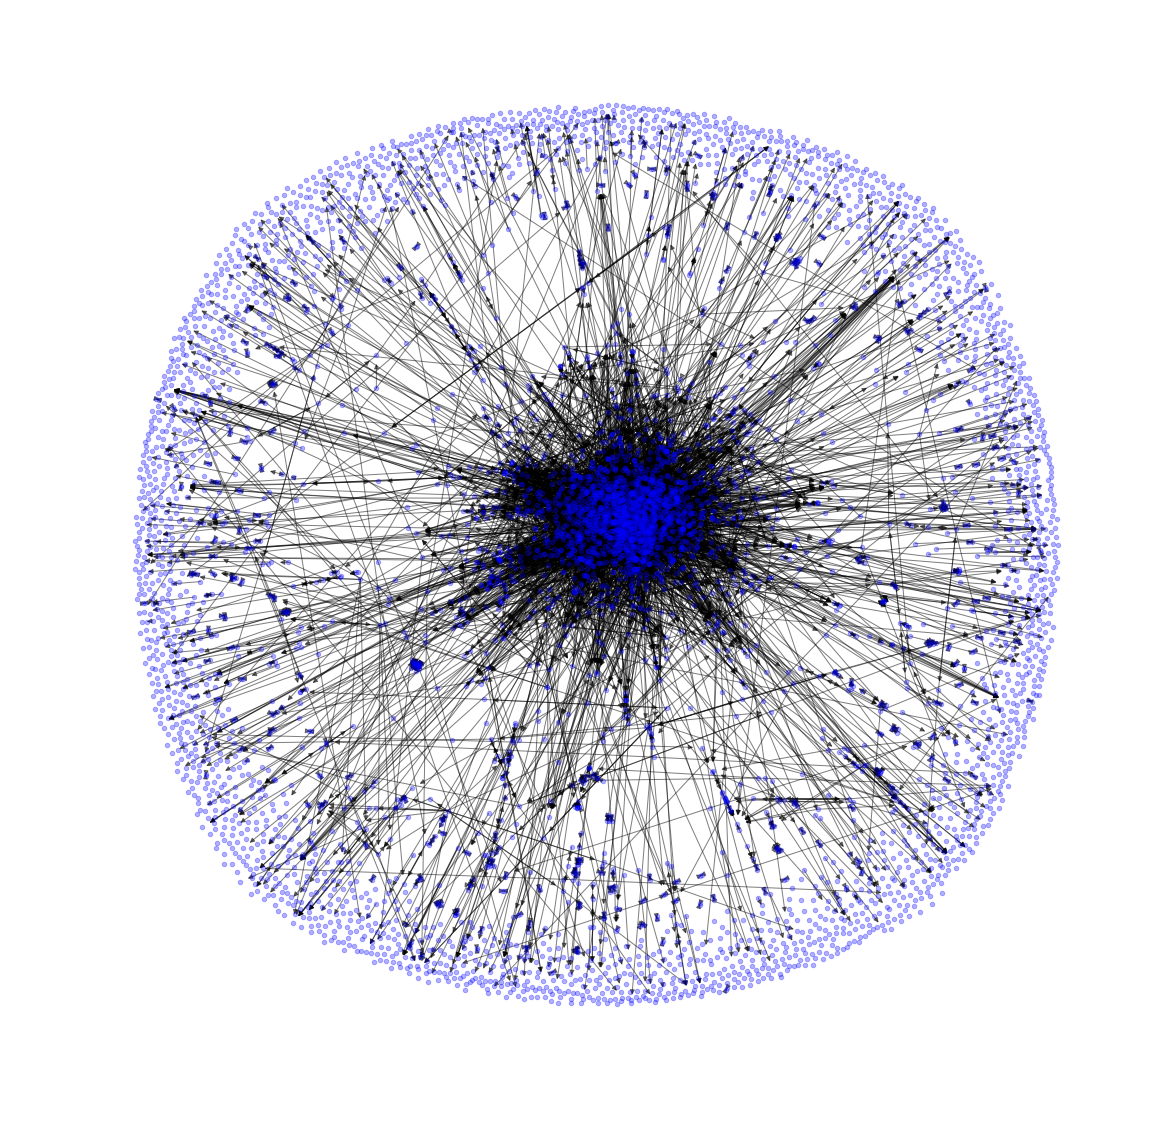

In [56]:
T = F.subgraph([elem[0] for elem in weight[0]] + [elem[0] for elem in weight[1]])
pos = nx.spring_layout(T)  # compute graph layout
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(T, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color='blue', alpha=0.3)
nx.draw_networkx_edges(T, pos, alpha=0.5)
plt.show(T)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


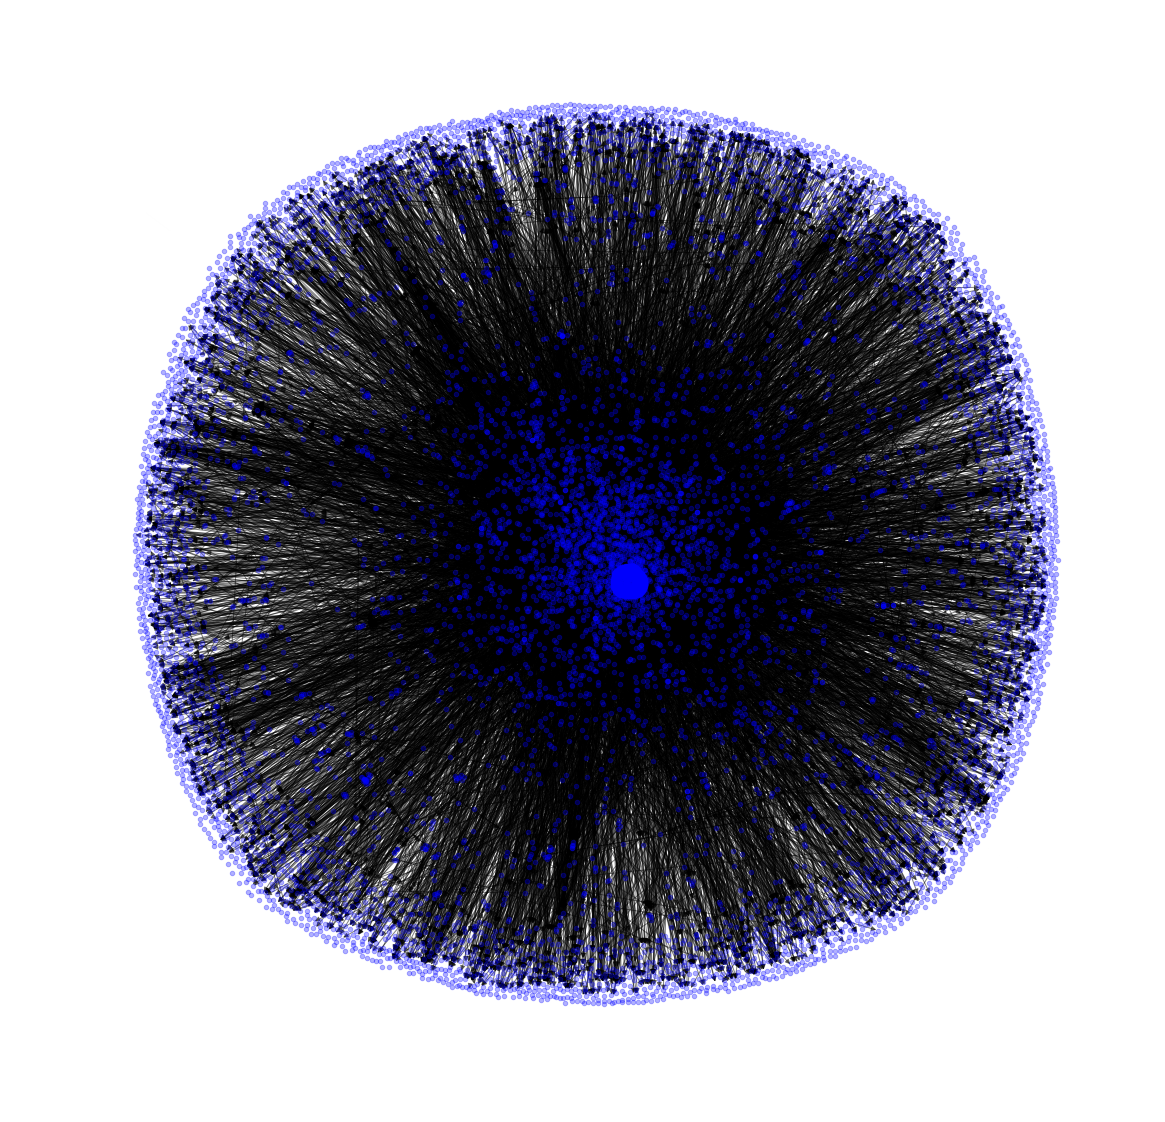

In [57]:
T = F.subgraph([elem[0] for elem in weight[0]] + [elem[0] for elem in weight[1]] + [elem[0] for elem in weight[2]] )
pos = nx.spring_layout(T)  # compute graph layout
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(T, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color='blue', alpha=0.3)
nx.draw_networkx_edges(T, pos, alpha=0.5)
plt.show(T)

As we can see, it's quite difficult to distinguish the nodes, expecially in the third plot.

# Another approach to do this homework:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from queue import Queue
import time
import statistics
import json
import itertools

__[RQ1]__ Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them, and provide its basic information:

In [2]:
# Creating graph from reduced set of nodes
graph=[]
G = nx.DiGraph()
for count, line in enumerate(open("wiki-topcats-reduced.txt")):
            grlst=line.replace("\n", "").split(sep="\t")
            graph.append((int(grlst[0]),int(grlst[1])))
            G.add_edge(int(grlst[0]),int(grlst[1]))

Function for defining if the graph is directed or not
basically this function check for each edge if there is reversed copy of the edge. If yes so graph is directed.

In [3]:
def is_directed(graph):
    for i in graph:
        if (i[1],i[0]) in graph: return True
    return False

To answer the questions for the RQ1 we use data frame.

In [4]:
df = pd.DataFrame(graph, columns=["A", "B"])
df.set_index("A")
print("Is Graph Directed:", is_directed(graph))     # just calling the is_directed function
print("Number of nodes:", len(set(df.A)|set(df.B))) # Number of nodes eaquals to the union of the sets 
                                                    # of initial nodes and the destination nodes 
print("Number of edges:", len(df))                  # because of that the graph is directed number of deges is number of rows in dataframe 
print("Average degree of nodes:", len(df)/len(set(df.A)|set(df.B))) # number of edges divided by the number of nodes
print("Density:", 2*len(G.edges())/(len(set(df.A)|set(df.B))*(len(set(df.A)|set(df.B))-1))) #Graph is not dense

Is Graph Directed: True
Number of nodes: 461193
Number of edges: 2645247
Average degree of nodes: 5.735661642739591
Density: 2.487320527129521e-05


__[RQ2]__ Given a category C_0 as input we want to rank all of the nodes in V according to the following criteria:

Filtering categories by the number of elements, by the set of nodes (counting only the nodes which are in reduced file),
by the number of elements one more time.

In [5]:
categoriesdata = {}
lst2=G.nodes()
with open('wiki-topcats-categories.txt') as f:
    for i, line in enumerate(f): 
        tmp = list(map(int, (line.split(';'))[1].split()))
        if len(tmp)>=3500:
            tmp=set(tmp).intersection(lst2)
            if len(tmp)>=3500:
                categoriesdata[i] =list(tmp)
f.close()

In [6]:
print('Number of correct categories:',len(categoriesdata))

Number of correct categories: 29


Detecting the smallest category by the number of elements in it.

In [7]:
INF=math.inf
minsub=[INF,INF,INF]
for i in categoriesdata:
    if len(categoriesdata[i]) < minsub[1]:
        minsub[0]=i
        minsub[1]=len(categoriesdata[i])
        minsub[2]=categoriesdata[i]
print('ID of the smallest category:',minsub[0],'\n','Number of elements:',minsub[1])

ID of the smallest category: 13996 
 Number of elements: 3720


Creating weighted undirected graph based on the set of categories.
Each node indicates one category
An edge between two categories categories indicates that the intersection of the selected categories is not an empty set
Each edge has a weight based on the number of computation between the intersection of two categories and the category 
which is the smaller one in each particular pair.

In [8]:
lst=[]
sm=0
H=nx.Graph()
intersection={}
for i,j in itertools.combinations(categoriesdata, 2):
        intersection[(i,j)]=set(categoriesdata[i]).intersection(categoriesdata[j])
        if len(intersection[(i,j)])!=0:
            if len(categoriesdata[i])<len(categoriesdata[j]):        
                    H.add_edge(i , j, weight=(1-1/(len(intersection[(i,j)])*len(categoriesdata[i]))))
            else:  H.add_edge(i , j, weight=(1-1/(len(intersection[(i,j)])*len(categoriesdata[j]))))

Plotting that graph 

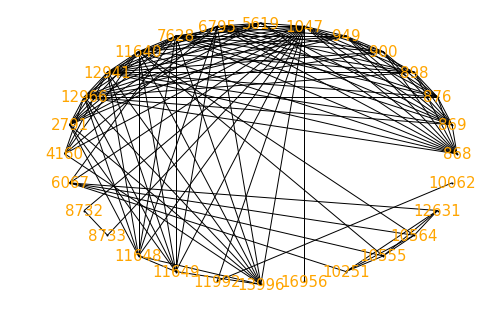

In [9]:
nx.draw_circular(H,with_labels = True, node_color="black", node_size=1, font_color="orange", font_size=15)
plt.draw()

In [10]:
# algorithm for finding the shortest path between two nodes of the graph based on dijkstra algoritm
def dijkstra_path(G,source,target):
    previous = distance = {} # dict for distances  # dict for predcessor nodes
    unvisited = list(G.nodes()) # list of all unvisited nodes (all of the nodes for zero step of iteration)
    path = [] # list for path
    for node in unvisited:
        distance[node] = INF #initializing all the distances as an infinite number
    distance[source] = 0 # distance between source node and itself is zero
 
    while unvisited: # while there is an unvisited nodes
        minVert = None # set the node with the minimal distance 
        for v in unvisited: # for each node in the list of unvisited nodes check
            if minVert is None:
                minVert = v
            elif distance[v] < distance[minVert]:
                minVert = v # reset the node with minimal distance
        for successor, weight in G[minVert].items():
            if weight['weight'] + distance[minVert] < distance[successor]:
                distance[successor] = weight['weight'] + distance[minVert]
                previous[successor] = minVert
        unvisited.remove(minVert)
 
    currentNode = target
    while currentNode != source:
        try:
            path.insert(0,currentNode)
            currentNode = previous[currentNode]
        except KeyError:
            print('Path not reachable')
            break
    path.insert(0,source)
    if distance[target] != INF:
        return path

We are going to set the category 13996 as the C_0 category because of that the smallest category require the minimal number of computations to obtain the block rank. With the following code we compute all the pathes with minimal weigth from C_0 category to every other category using dijkstra path


In [11]:
path_edge={}
for i in H.nodes():
    if i!=13996:
        lst = dijkstra_path(H, i, 13996)
        if len(lst)>2:
            tmp=[]
            for j in range(0,len(lst)-1):
            # Here we should be accurate
            # We can place the smaller category to the zero position in each edge tuple because the category graph is undirected
            # It is done for the purpose of conviniency
                if len(categoriesdata[lst[j]])<len(categoriesdata[lst[j+1]]):  tmp.append((lst[j],lst[j+1]))
                else:  tmp.append((lst[j+1],lst[j]))
            if i in path_edge:  path_edge[i].append(tmp)
            else: path_edge[i]=tmp
        else:
            if len(categoriesdata[lst[0]])<len(categoriesdata[lst[1]]):  path_edge[i]=[(lst[0],lst[1])]
            else:  path_edge[i]=[(lst[1],lst[0])]

This category consist of destination categories as keys 
and list of edges which connect the source category C_0 with the destination category

In [12]:
path_edge 

{868: [(11640, 868), (13996, 11640)],
 869: [(12966, 869), (13996, 12966)],
 876: [(876, 12966), (13996, 12966)],
 898: [(898, 12966), (13996, 12966)],
 900: [(12966, 900), (13996, 12966)],
 949: [(949, 11640), (13996, 11640)],
 1047: [(13996, 1047)],
 5619: [(12966, 5619), (13996, 12966)],
 6795: [(13996, 6795)],
 7628: [(13996, 7628)],
 11640: [(13996, 11640)],
 12941: [(13996, 12941)],
 12966: [(13996, 12966)],
 2791: [(13996, 2791)],
 4160: [(13996, 4160)],
 6067: [(6067, 7628), (13996, 7628)],
 8732: [(8732, 1047), (13996, 1047)],
 8733: [(8733, 1047), (13996, 1047)],
 11648: [(13996, 11648)],
 11649: [(13996, 11649)],
 11992: [(11992, 1047), (13996, 1047)],
 16956: [(16956, 1047), (13996, 1047)],
 10251: [(10251, 6067), (6067, 7628), (13996, 7628)],
 10555: [(11640, 10555), (13996, 11640)],
 10564: [(11640, 10564), (13996, 11640)],
 12631: [(6067, 12631), (6067, 7628), (13996, 7628)],
 10062: [(10062, 11992), (11992, 1047), (13996, 1047)]}

Creating the list of all edges which should be computed

In [13]:
list_path_edge=[]
for i in path_edge:
    for j in path_edge[i]:
        list_path_edge.append(j)
list_path_edge=set(list_path_edge)

In [14]:
for i in list_path_edge:
    print(i,'\t',len(categoriesdata[i[0]]),'\t',len(categoriesdata[i[1]]))

(13996, 11648) 	 3720 	 11531
(13996, 2791) 	 3720 	 5549
(8733, 1047) 	 4895 	 348300
(13996, 1047) 	 3720 	 348300
(898, 12966) 	 3737 	 5532
(13996, 11649) 	 3720 	 13865
(8732, 1047) 	 11660 	 348300
(11640, 10555) 	 4614 	 22463
(13996, 12966) 	 3720 	 5532
(11640, 10564) 	 4614 	 15159
(10251, 6067) 	 4422 	 5568
(949, 11640) 	 4588 	 4614
(13996, 4160) 	 3720 	 5192
(13996, 12941) 	 3720 	 4346
(16956, 1047) 	 4025 	 348300
(10062, 11992) 	 4760 	 7561
(11640, 868) 	 4614 	 7538
(6067, 7628) 	 5568 	 28498
(6067, 12631) 	 5568 	 10759
(12966, 869) 	 5532 	 7814
(12966, 5619) 	 5532 	 6491
(12966, 900) 	 5532 	 5827
(13996, 7628) 	 3720 	 28498
(876, 12966) 	 5097 	 5532
(13996, 11640) 	 3720 	 4614
(13996, 6795) 	 3720 	 4122
(11992, 1047) 	 7561 	 348300


Plot of the graph with optimal routes to compute the distances

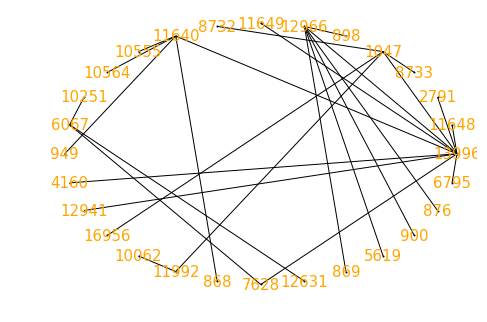

In [15]:
GH=nx.Graph()
GH.add_edges_from(list_path_edge)
nx.draw_circular(GH,with_labels = True, node_color="black", node_size=1, font_color="orange", font_size=15)
plt.draw()

Creating a dictionary of intersections for the edges in the list_path_edge

In [16]:
intersections={}
sumcomp=0
print('edge','\t','\t','intersection','\t','computations')
for i in list_path_edge:
    if i in intersection: intersections[i] = intersection[i]
    elif (i[1],i[0]) in intersection: intersections[i] = intersection[(i[1],i[0])]
    sumcomp+=len(intersections[i])*len(categoriesdata[i[0]]) 
    
    #computation is provided between intersection nodes of two categories with all the nodes of the smaller category.
    
    print(i,'\t',len(intersections[i]),'\t','\t',len(intersections[i])*len(categoriesdata[i[0]]))
print('Total computations',sumcomp)

edge 	 	 intersection 	 computations
(13996, 11648) 	 177 	 	 658440
(13996, 2791) 	 118 	 	 438960
(8733, 1047) 	 2 	 	 9790
(13996, 1047) 	 463 	 	 1722360
(898, 12966) 	 13 	 	 48581
(13996, 11649) 	 232 	 	 863040
(8732, 1047) 	 1 	 	 11660
(11640, 10555) 	 1 	 	 4614
(13996, 12966) 	 2 	 	 7440
(11640, 10564) 	 1 	 	 4614
(10251, 6067) 	 6 	 	 26532
(949, 11640) 	 1 	 	 4588
(13996, 4160) 	 61 	 	 226920
(13996, 12941) 	 24 	 	 89280
(16956, 1047) 	 1 	 	 4025
(10062, 11992) 	 910 	 	 4331600
(11640, 868) 	 1 	 	 4614
(6067, 7628) 	 1 	 	 5568
(6067, 12631) 	 131 	 	 729408
(12966, 869) 	 11 	 	 60852
(12966, 5619) 	 6 	 	 33192
(12966, 900) 	 26 	 	 143832
(13996, 7628) 	 4 	 	 14880
(876, 12966) 	 19 	 	 96843
(13996, 11640) 	 116 	 	 431520
(13996, 6795) 	 12 	 	 44640
(11992, 1047) 	 1 	 	 7561
Total computations 10025354


Separating the input C_0 category from the other ones

In [17]:
for i in categoriesdata:
    if i!=13996:
        categoriesdata[i]=list(set(categoriesdata[i])-set(categoriesdata[i]).intersection(categoriesdata[13996]))

In [18]:
def BFS(graph, srcnode, destnode, predcessor, distance):
        q = Queue() 
        visited={}
        for node in G.nodes():
                visited[node] = False
                distance[node] = math.inf
                predcessor[node] = -1

        visited[srcnode] = True; 
        distance[srcnode] = 0; 
        q.put(srcnode); 

        while (q.empty()==False):
                node = q.get()
                for neinode in G.neighbors(node):
                        if visited[neinode] == False :
                                visited[neinode] = True
                                distance[neinode]= distance[node]+1
                                predcessor[neinode] = node
                                q.put(neinode)
                        if neinode == destnode: 
                                return True
        return False
    
def shortest_path_length(graph, srcnode, destnode):
        predcessor={}
        distance={} 
        if (BFS(graph, srcnode, destnode, predcessor, distance) == False):
                                raise ValueError('could not find path')
        return distance[destnode]

In [19]:
# Computing the distances between categories
distance={} # dictionary where we store edges between the categories as keys and the distance as values
for i in list_path_edge: # pick a pair of categories
    for j in intersections[i]: # for each element in itersection
            for k in categoriesdata[i[0]]: # and for each element from smaller category
                try: # compute the shortest path in both ways
                    x = shortest_path_length(G, j, k)
                # all the values of shortest path function are stored in a list
                    if i in distance:
                        distance[i].append(x)
                    else:distance[i]=[x]
                except:
                    x = -1
                try:
                    y = shortest_path_length(G, k, j)
                    if i in distance:
                        distance[i].append(y)
                    else:distance[i]=[y]
                except:
                    y = -1
    if i in distance:
        # computing the median from the list of values
        median=statistics.median(distance[i])
        if median == float(0): distance[i]=0.5
        else:distance[i]=median
    print(i, distance[i])

(13996, 11648) 4
(13996, 2791) 5.0
(8733, 1047) 7.0
(13996, 1047) 5
(898, 12966) 6
(13996, 11649) 4
(8732, 1047) 0.5
(11640, 10555) 5.0
(13996, 12966) 5
(11640, 10564) 5.0
(10251, 6067) 5.0
(949, 11640) 7
(13996, 4160) 5
(13996, 12941) 5
(16956, 1047) 6
(10062, 11992) 5.0
(11640, 868) 7.0
(6067, 7628) 4.0
(6067, 12631) 5
(12966, 869) 7.0
(12966, 5619) 6.0
(12966, 900) 7.0
(13996, 7628) 5
(876, 12966) 6
(13996, 11640) 5
(13996, 6795) 5.0
(11992, 1047) 5.0


Creating a block rank based on the precomputed distances between categories.

In [22]:
tmp={}
blockrank={}
for i in path_edge:
    for j in path_edge[i]:
        if i in tmp: tmp[i] += distance[j]
        else: tmp[i] = distance[j]
blckrnk = sorted(tmp.items(), key=lambda kv: kv[1])
for i in blckrnk:
    blockrank[i[0]]=i[1]
blockrank

{11648: 4,
 11649: 4,
 1047: 5,
 6795: 5.0,
 7628: 5,
 11640: 5,
 12941: 5,
 12966: 5,
 2791: 5.0,
 4160: 5,
 8732: 5.5,
 6067: 9.0,
 11992: 10.0,
 10555: 10.0,
 10564: 10.0,
 876: 11,
 898: 11,
 5619: 11.0,
 16956: 11,
 868: 12.0,
 869: 12.0,
 900: 12.0,
 949: 12,
 8733: 12.0,
 10251: 14.0,
 12631: 14.0,
 10062: 15.0}

In [23]:
import json
with open('blockrank.json', 'a') as outfile:
    json.dump(blockrank, outfile)
    
blockranklist=[i for i in blockrank]
print(blockranklist)

[11648, 11649, 1047, 6795, 7628, 11640, 12941, 12966, 2791, 4160, 8732, 6067, 11992, 10555, 10564, 876, 898, 5619, 16956, 868, 869, 900, 949, 8733, 10251, 12631, 10062]


For the second part of RQ2 we should clean our categories according block rank
for this purpose we pick all the pairwise combinations of the categories with the order in blockrank list
and remove the nodes from the category with lower ranking

In [28]:
disjunctcategories={}
disjunctcategories[13996]=categoriesdata[13996]
disjunctcategories[blockranklist[0]]=categoriesdata[blockranklist[0]]
for i,j in itertools.combinations(blockranklist, 2):
    disjunctcategories[j]=set(categoriesdata[j])-set(categoriesdata[j]).intersection(categoriesdata[i])

Let's see if it works We can see that in the input category there is not any changes. That is correct.
There is not any changes also in the category from the position in our rank. That is correct
Then we can observe that in some categories number of nodes after cleaning is less than the number of nodes before

In [27]:
for i in disjunctcategories:
    print(i,'\t', len(categoriesdata[i]),'\t', len(disjunctcategories[i]))

13996 	 3720 	 3720
11648 	 11354 	 11354
11649 	 13633 	 4819
1047 	 347837 	 338682
6795 	 4110 	 4108
7628 	 28494 	 28494
11640 	 4498 	 4309
12941 	 4322 	 4311
12966 	 5530 	 5515
2791 	 5431 	 5369
4160 	 5131 	 5131
8732 	 11660 	 11660
6067 	 5568 	 5568
11992 	 7561 	 7561
10555 	 22463 	 22463
10564 	 15159 	 4628
876 	 5097 	 5097
898 	 3737 	 3730
5619 	 6491 	 6491
16956 	 4025 	 4025
868 	 7538 	 7538
869 	 7814 	 2794
900 	 5827 	 4316
949 	 4588 	 4298
8733 	 4895 	 4895
10251 	 4422 	 4422
12631 	 10759 	 10157
10062 	 4760 	 4760


In this part we are creating code which allow us to score the nodes. The code below score the nodes based on the number of their not boundary in_edges. Then we select all the boundary edges for each category in the order of the blockrank and add the score of the source edge to the score of target edge. We can do that because the graph we are working with is the initial directed graph with 461193 nodes.


In [47]:
for i in blockranklist: # for each category
    for j in disjunctcategories[i]:  # for each node in that category
        pred = set(G.predecessors(j)).intersection(disjunctcategories[i]) # compute the number of in_edges from the same category
        G.nodes[j]['score'] = len(pred)                                   # set the score of the node as number of it`s in_edges 

current = disjunctcategories[13996] # set of nodes in input category is initial state of our graph
for k in disjunctcategories: # for each category
    if k!=13996:
        for j in nx.edge_boundary(G, current, disjunctcategories[k]): # for each boundary edge of the category 
                try:
                    G.nodes[j[1]]['score'] += G.nodes[j[0]]['score'] # The score of source node is added to the score of target node
                except:
                    try:
                        G.nodes[j[1]]['score'] += 0
                    except:
                        G.nodes[j[1]]['score'] = 0
        current+=disjunctcategories[k] # add the categories one by one during each iteration to the current state of the graph